# Introduction to Research module

## Roadmap

* Basic example
    * 1 pipeline with fixed parameters
         * creating research
         * running several repetitions of an experiment
         * defining results recording frequency aka execute='%n'
         * viewing research results
         * saving and loading research
* Runnung experiments with different parameters aka grid
    * 1 pipeline with variable parameters
         * creating and viewing grids
         * viewing filtered research results
* Reducing extra dataset loads
    * 1 pipeline with root and brunch + grid
* More complex execution strategies
    * 2 pipelines, train & test + function + root&brunch + grid
        * adding test pipeline
        * adding functions
* Cross-validation

* Performance
        * execution tasks managing
* Combining it all together
    * Super complex Research

## Basic example

In [1]:
import sys
sys.path.append('../../..')

import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

In [2]:
BATCH_SIZE=64
ITERATIONS=10

In [3]:
mnist = MNIST()
train_root = mnist.train.p.run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [4]:
model_config={
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('loss', mode='w'))
)

train_ppl = train_root + train_template

In [5]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train'))

research.run(n_reps=4, n_iters=ITERATIONS, name='my_research', bar=True)

Research my_research_3 is starting...
Distributor has 4 jobs with 10 iterations. Totally: 40


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:59<00:00,  1.49s/it]


Each research is assigned with a unique name starting with *name* argument provided to *run*.
Results of the research and its log are saved in a folder with the same name in the working directory

In [6]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 9
Data columns (total 4 columns):
repetition    40 non-null int64
name          40 non-null object
loss          40 non-null float64
iteration     40 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.6+ KB


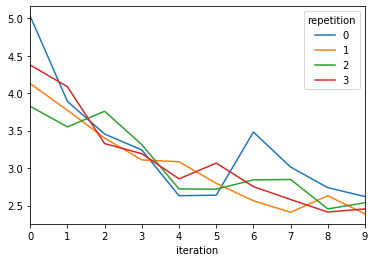

In [7]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

In [8]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', execute='%5', name='train'))
research.run(n_reps=4, n_iters=ITERATIONS, name='my_research', bar=True)

Research my_research_4 is starting...
Distributor has 4 jobs with 10 iterations. Totally: 40


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:56<00:00,  1.42s/it]


In [9]:
results = research.load_results()
results

,repetition,name,loss,iteration
0,0,train,4.021315,4
1,0,train,3.860271,9
0,1,train,4.207128,4
1,1,train,3.803846,9
0,2,train,4.215681,4
1,2,train,3.843799,9
0,3,train,4.807958,4
1,3,train,3.989471,9


### Saving & Loading

TODO

## Introducing grids

In [10]:
grid = (Option('layout', ['cna', 'can']) * Option('model', [VGG7, VGG16]) * Option('bias', [False])
        +  Option('layout', ['cna']) * Option('bias', [True]) * Option('model', [VGG7]))
list(grid.gen_configs())

[ConfigAlias({'layout': 'cna', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'bias': 'True', 'model': 'VGG7'})]

In [11]:
model_config={
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', C('model'), 'conv', config=model_config)
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('loss', mode='w'))
)

train_ppl = train_root + train_template

In [12]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_grid(grid))

research.run(n_reps=2, n_iters=ITERATIONS, name='my_research', bar=True)


Research my_research_5 is starting...
Distributor has 10 jobs with 10 iterations. Totally: 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


In [13]:
results = research.load_results()
results.head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.645154,VGG7,train,0
1,False,1,cna,3.663610,VGG7,train,0
2,False,2,cna,3.252170,VGG7,train,0
3,False,3,cna,3.155734,VGG7,train,0
4,False,4,cna,3.230785,VGG7,train,0


In [14]:
results = research.load_results(use_alias=True)
results.head()

,repetition,name,loss,iteration,config
0,0,train,4.645154,0,bias_False-layout_cna-model_VGG7
1,0,train,3.663610,1,bias_False-layout_cna-model_VGG7
2,0,train,3.252170,2,bias_False-layout_cna-model_VGG7
3,0,train,3.155734,3,bias_False-layout_cna-model_VGG7
4,0,train,3.230785,4,bias_False-layout_cna-model_VGG7


In [15]:
research.load_results(aliases={'model': 'VGG7'}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.645154,VGG7,train,0
1,False,1,cna,3.663610,VGG7,train,0
2,False,2,cna,3.252170,VGG7,train,0
3,False,3,cna,3.155734,VGG7,train,0
4,False,4,cna,3.230785,VGG7,train,0


In [16]:
research.load_results(configs={'model': VGG7}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.645154,VGG7,train,0
1,False,1,cna,3.663610,VGG7,train,0
2,False,2,cna,3.252170,VGG7,train,0
3,False,3,cna,3.155734,VGG7,train,0
4,False,4,cna,3.230785,VGG7,train,0


In [17]:
research.load_results(repetitions=1, iterations=[0,9]).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.349426,VGG7,train,1
1,False,9,cna,2.360284,VGG7,train,1
0,False,0,cna,7.187845,VGG16,train,1
1,False,9,cna,5.251336,VGG16,train,1
0,False,0,can,4.559404,VGG7,train,1
